In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from pathlib import Path
import numpy as np
import seaborn as sns
import result_handler as rh
from sklearn.metrics import confusion_matrix, f1_score, precision_score, accuracy_score, recall_score
from utils import MODELS_MAP, DATASETS_MAPS, plot_metrics_results, plot_models_benchmark_results, mount_metrics_dataframe


In [2]:
RELOAD_DATA = False
RESULTS_DIR = Path('../translations')
RESULTS_NAME = 'cross_tests_results_final.csv'

if RELOAD_DATA:
    rh.concatenate_csv_files(RESULTS_DIR, 'predictions.csv', RESULTS_NAME)

df = pd.read_csv(RESULTS_NAME)
df['test_dataset'] = df['test_dataset'].map(DATASETS_MAPS)
df['train_dataset'] = df['train_dataset'].map(DATASETS_MAPS)
df['model_name'] = df['model_name'].map(MODELS_MAP)

In [3]:
grouped = df.groupby(['model_name', 'train_dataset', 'test_dataset'])
normalize = 'true' #Normalize the confusion matrix by row (true) or by column (pred)
def plot_consufion_matrices(grouped: pd.DataFrame, normalize: str = 'true'):
    if normalize == 'true':
        norm = 'by the true labels'
    else:
        norm = 'by the predicted labels'

    for (model, train_ds, test_ds), group in grouped:
        # Compute confusion matrix
        labels = sorted(set(group['label'].unique().tolist() + group['prediction'].unique().tolist()))
        cm = confusion_matrix(group['label'], group['prediction'], labels=labels, normalize=normalize)
        
        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt=".2f", vmin = 0, vmax = 1, cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title(f'Model: {model}\nTrain Dataset: {train_ds}\nTest Dataset: {test_ds}\n Normalized by {norm}', loc = 'left')
        plt.show()


In [4]:
df[df['model_name'] == 'xlm-roberta-base'].groupby(['train_dataset', 'test_dataset']).count()

,,model_name,index,prediction,label
train_dataset,test_dataset,,,,


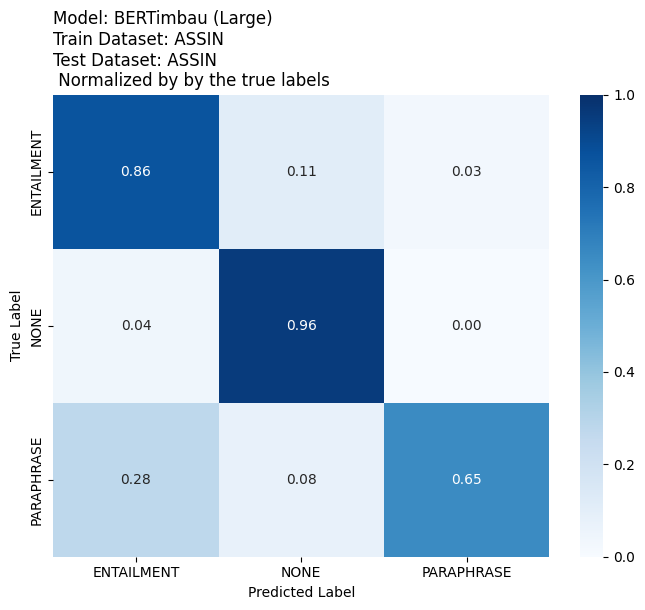

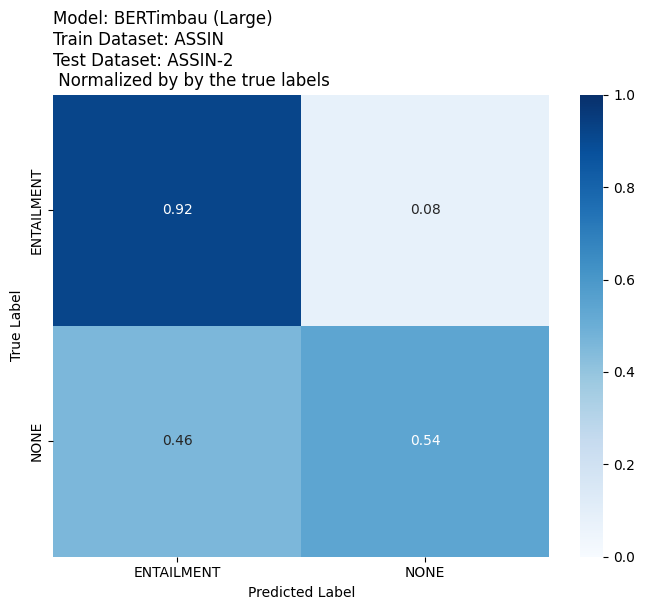

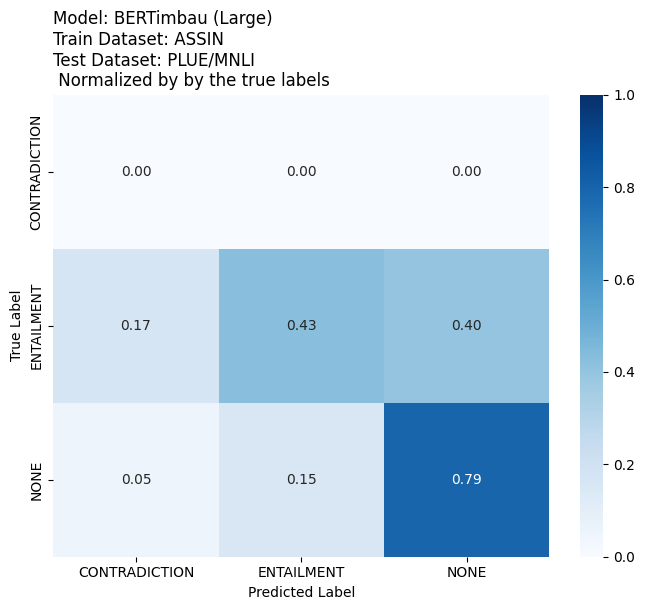

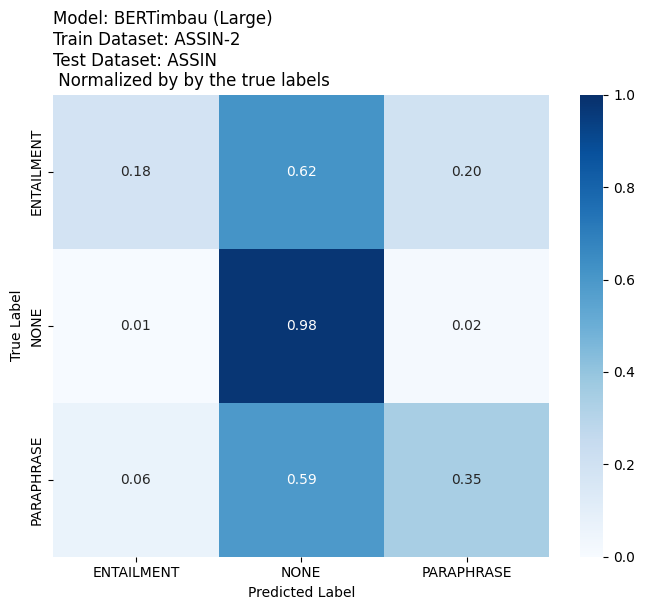

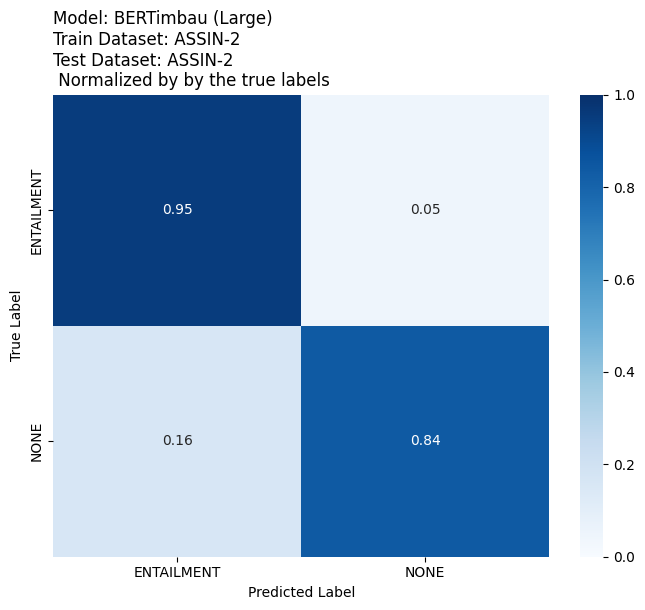

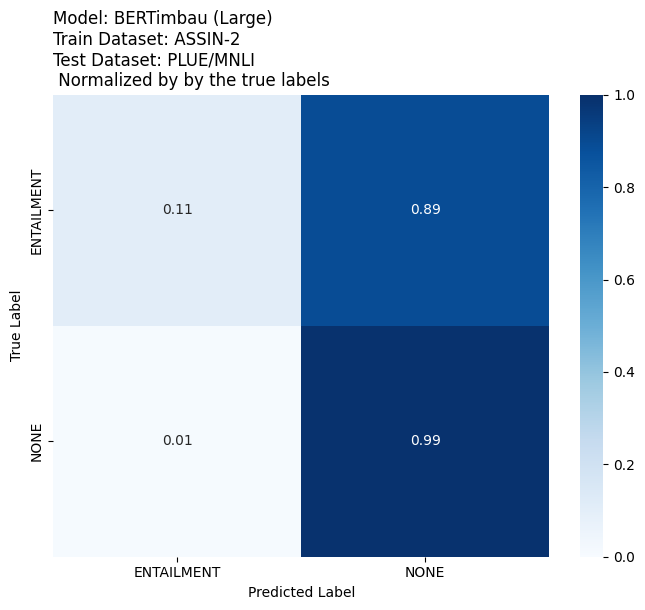

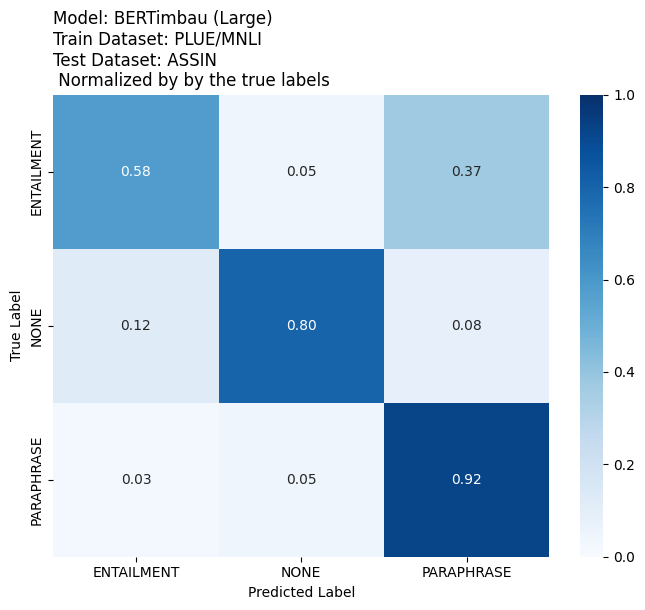

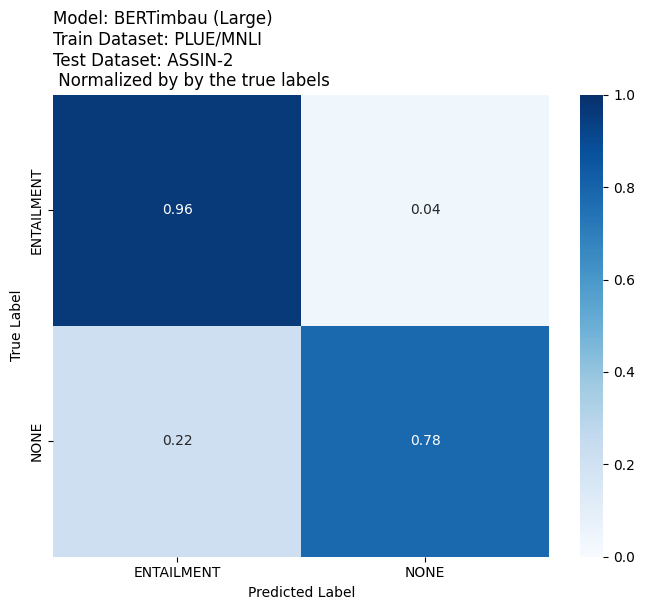

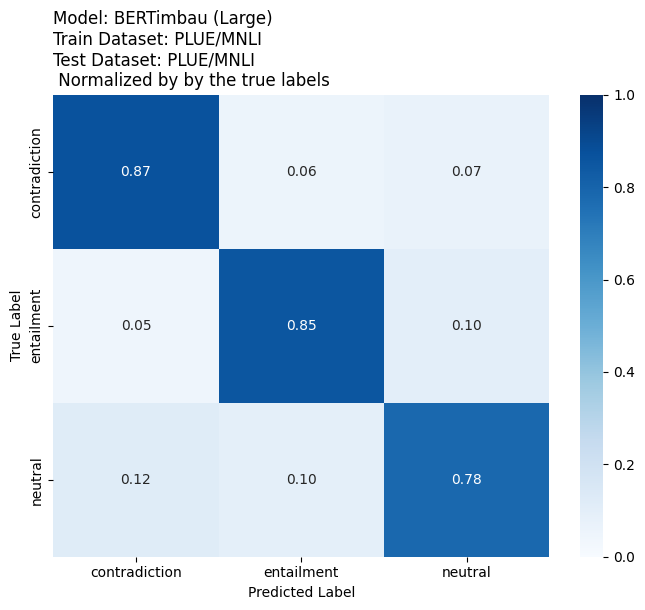

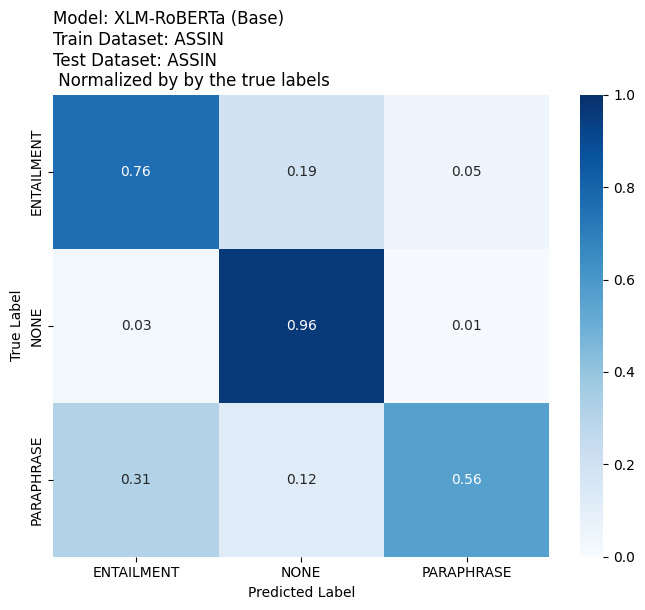

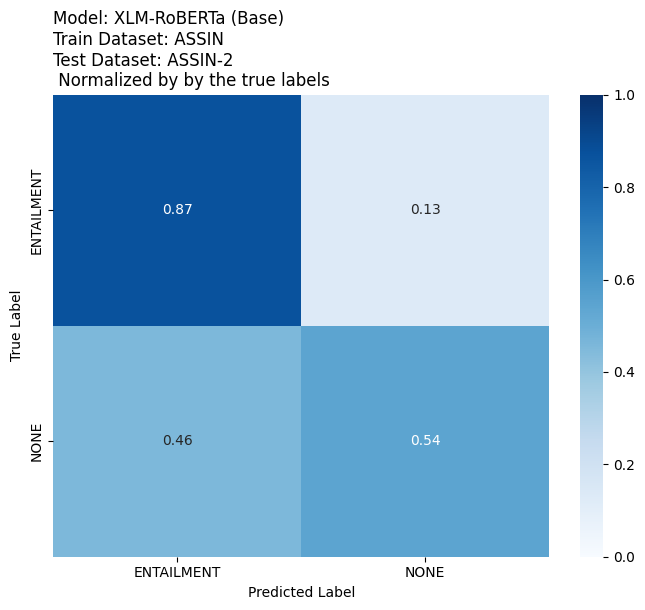

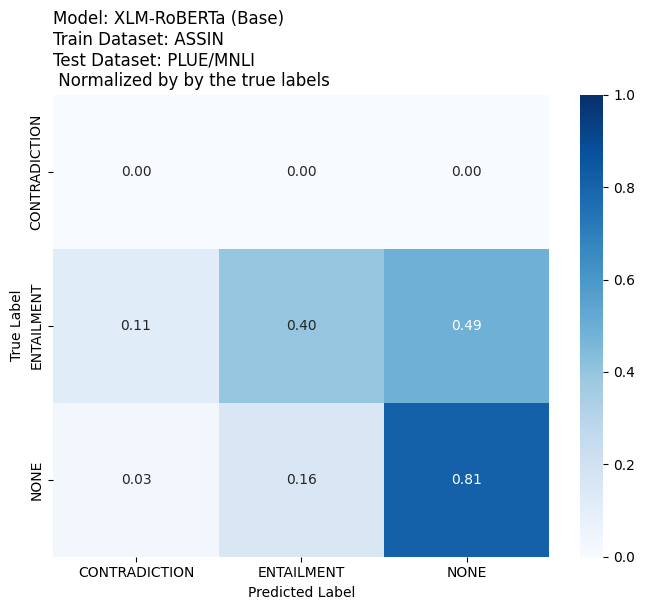

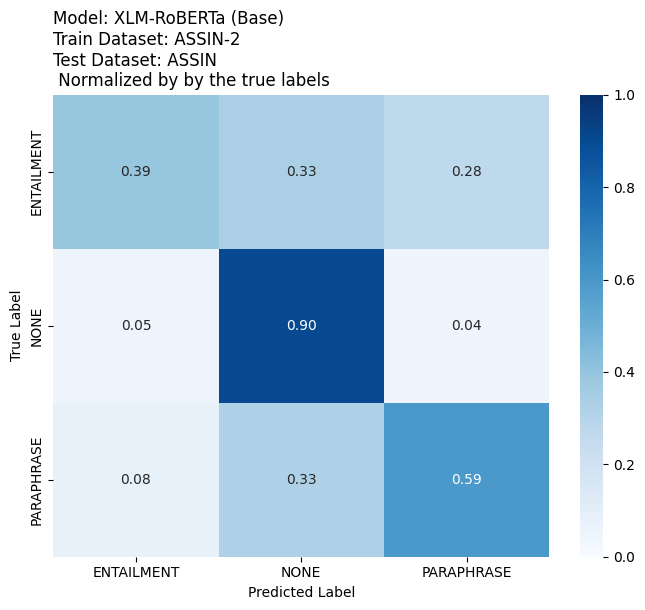

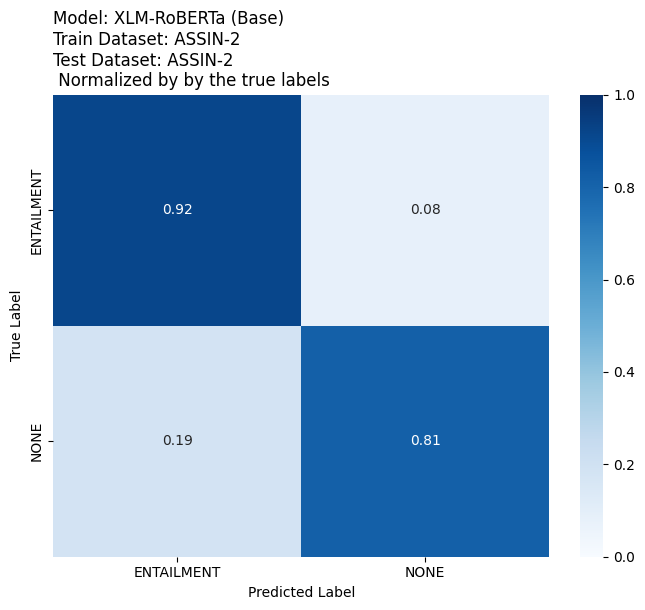

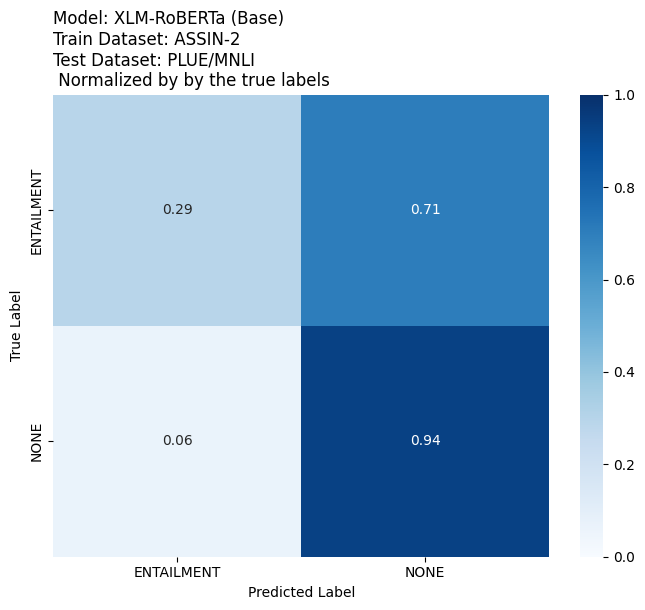

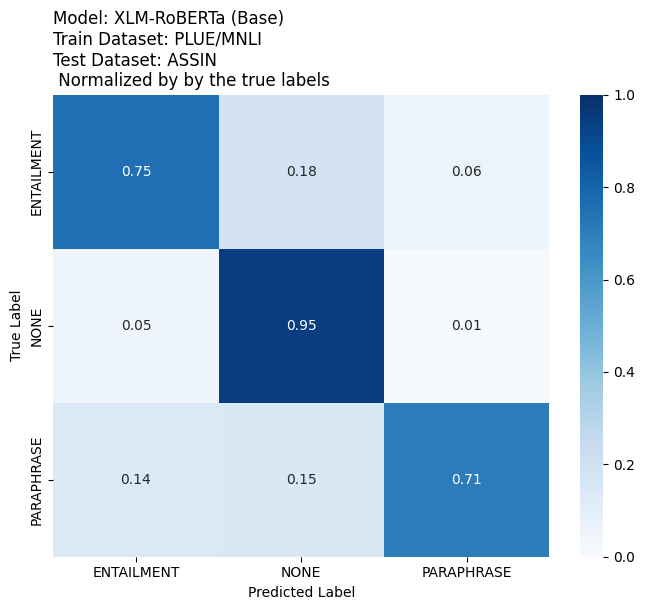

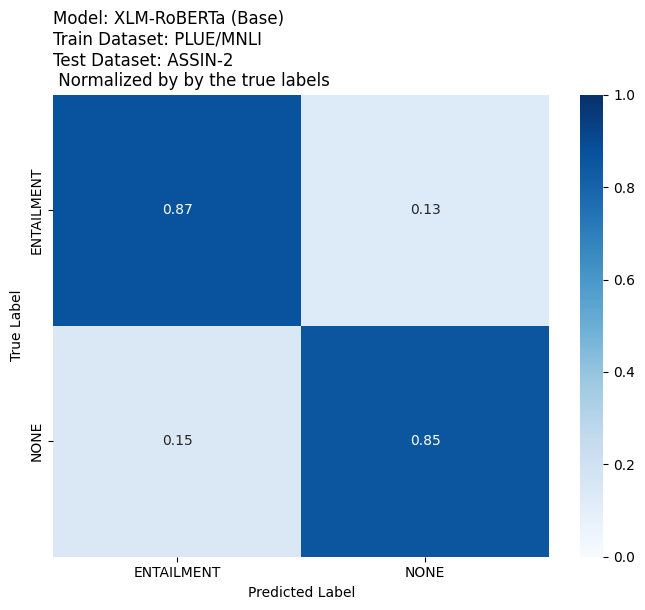

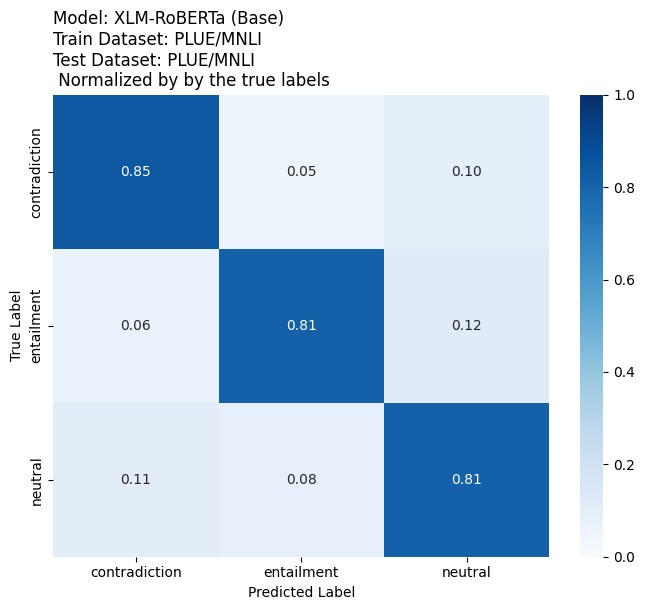

In [5]:
plot_consufion_matrices(grouped, normalize='true')  

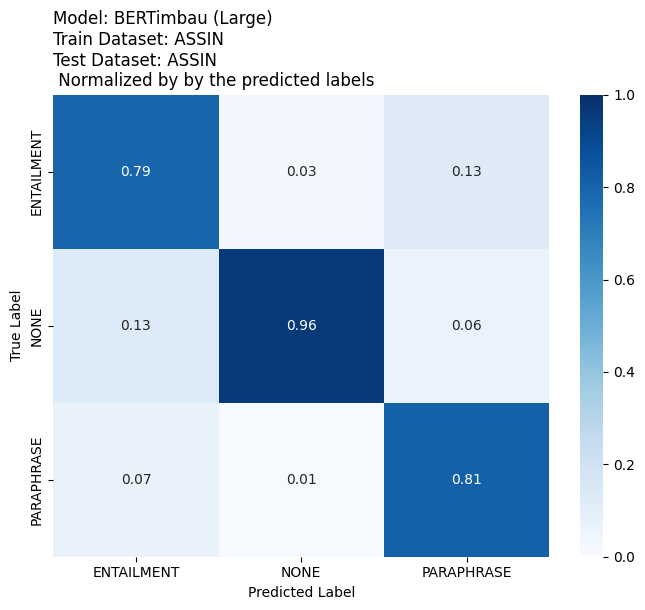

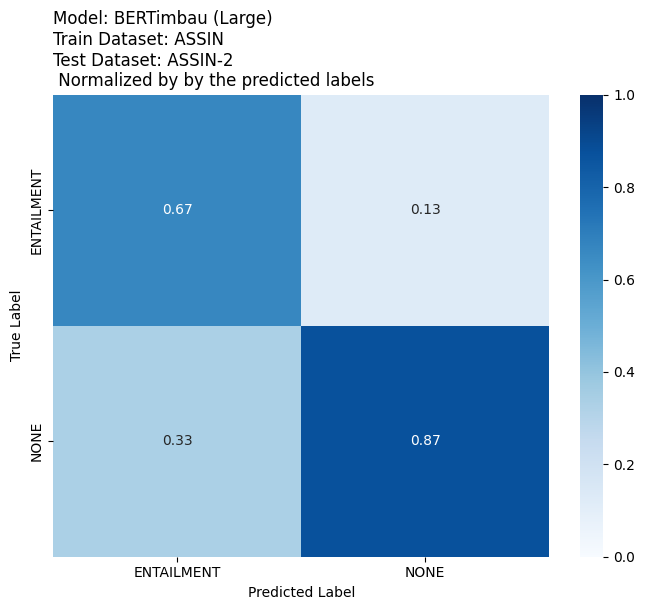

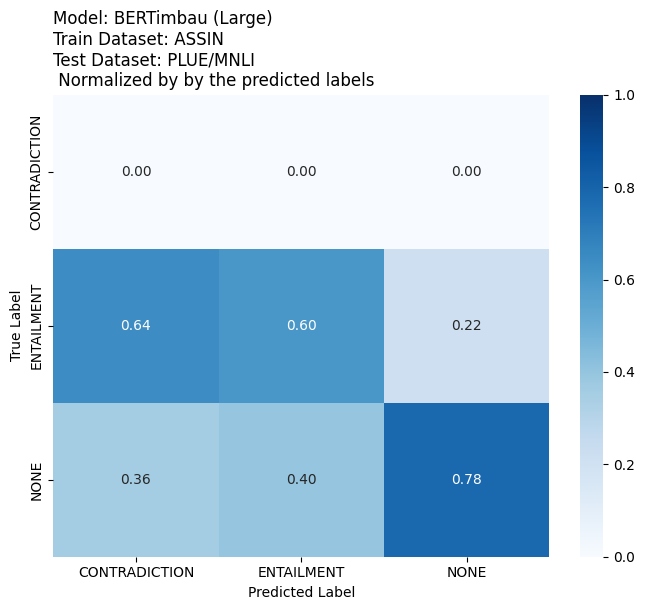

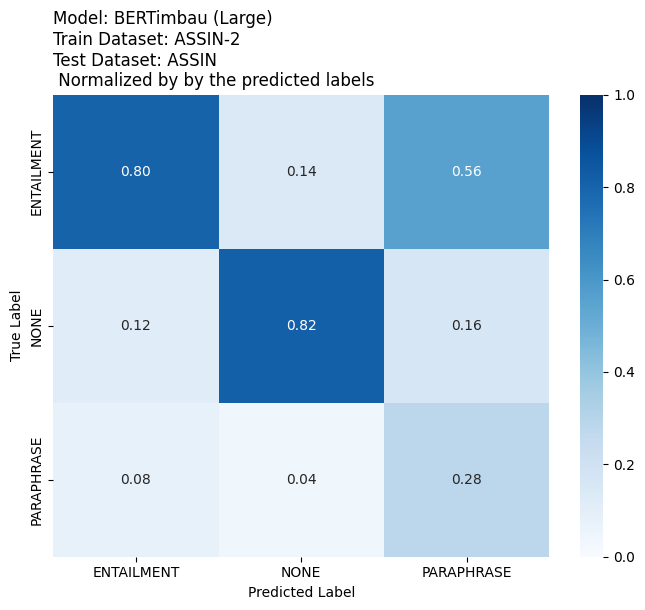

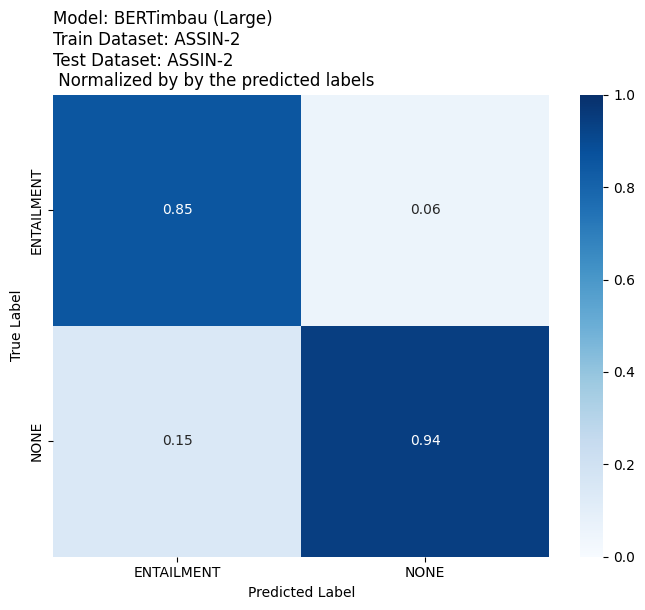

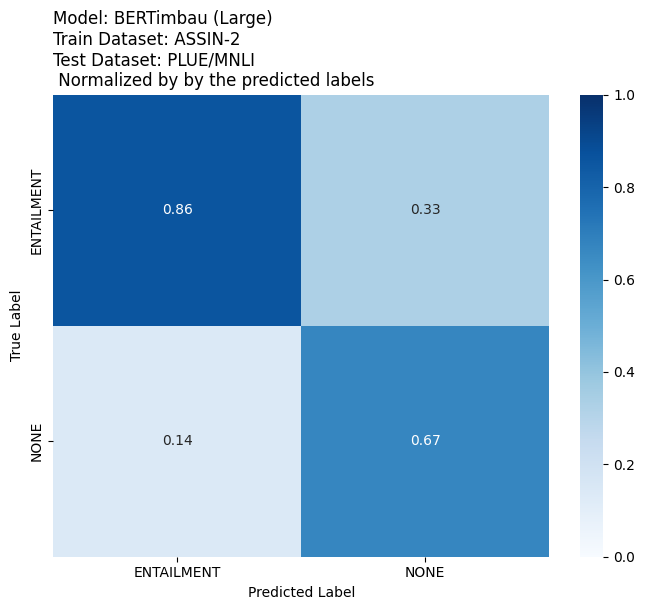

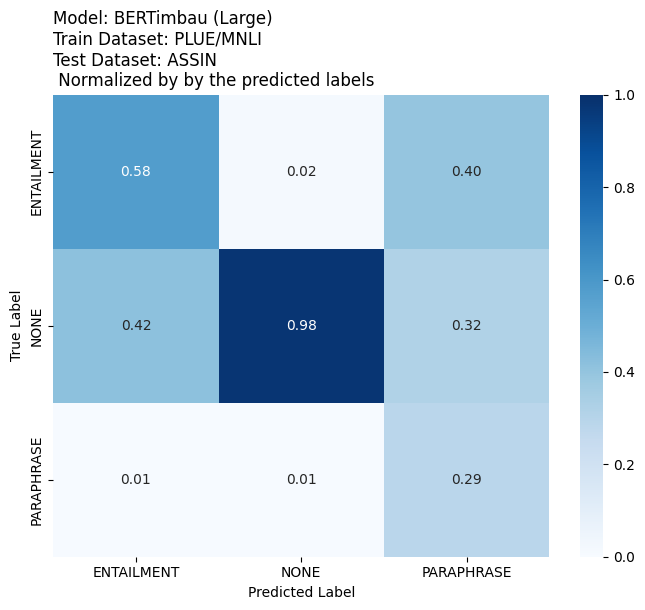

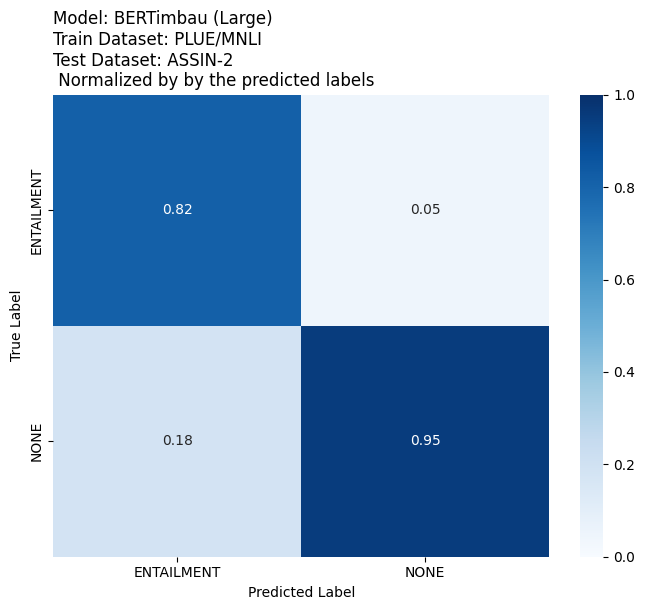

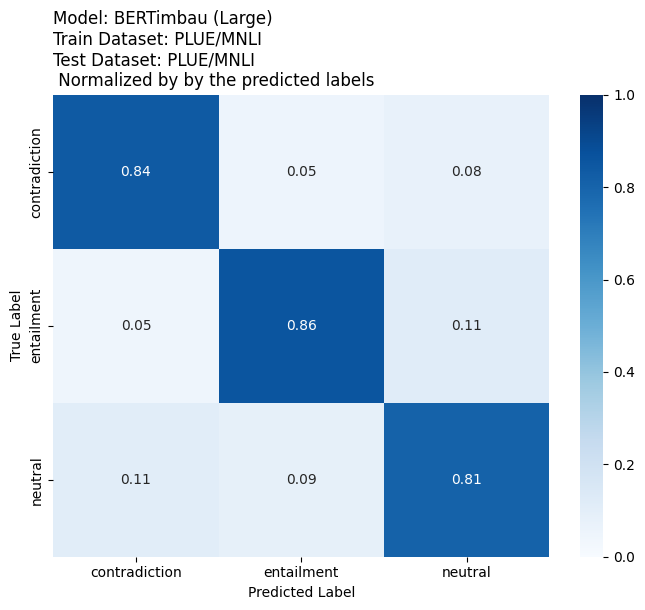

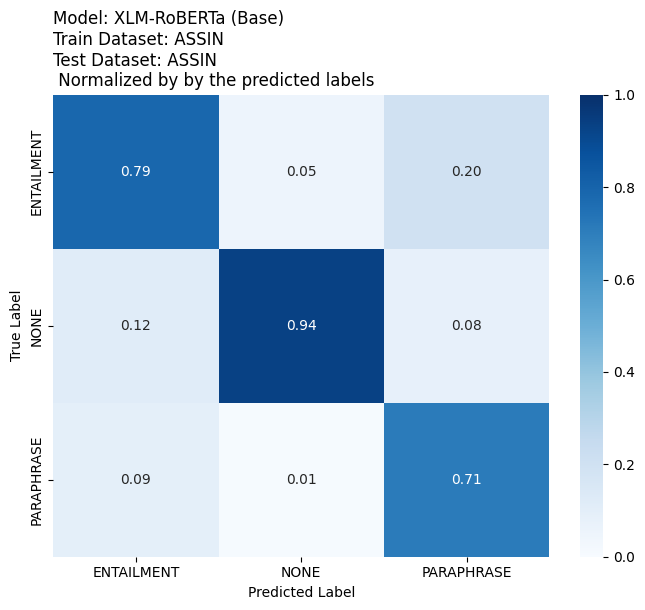

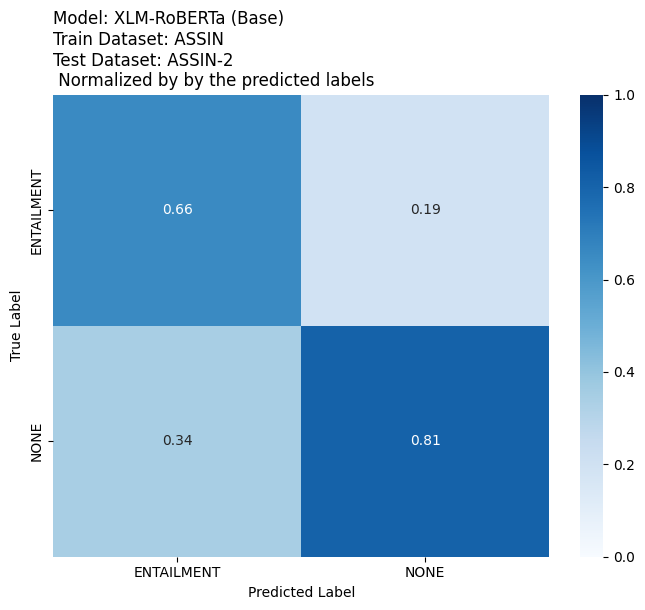

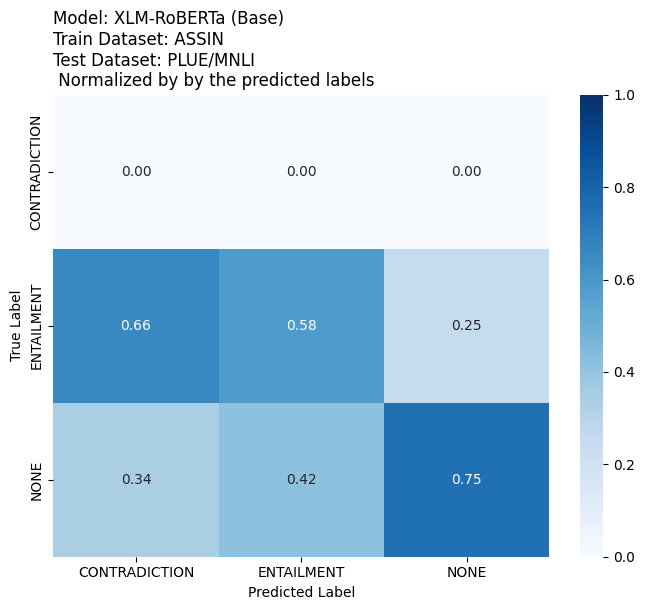

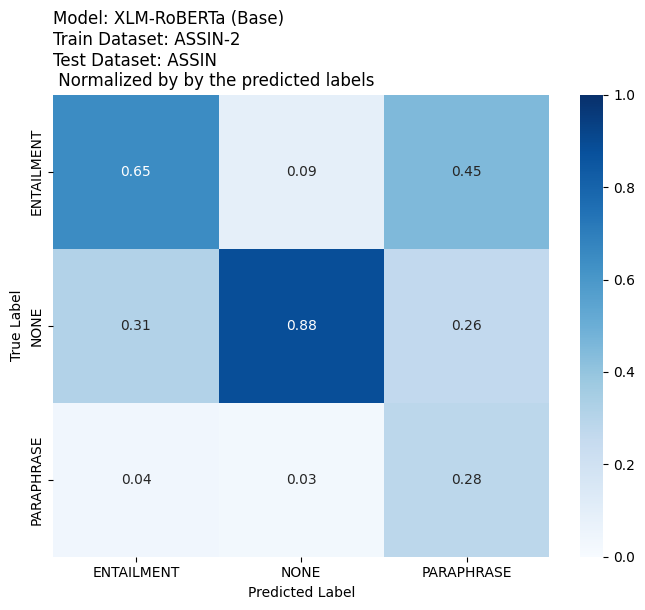

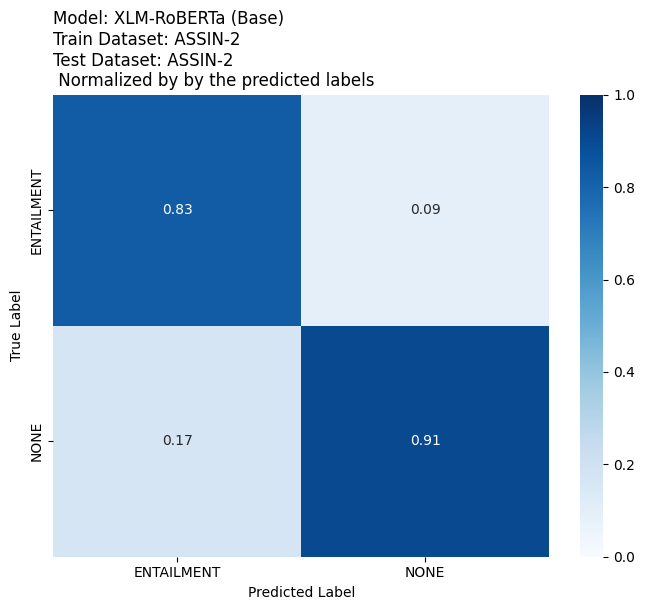

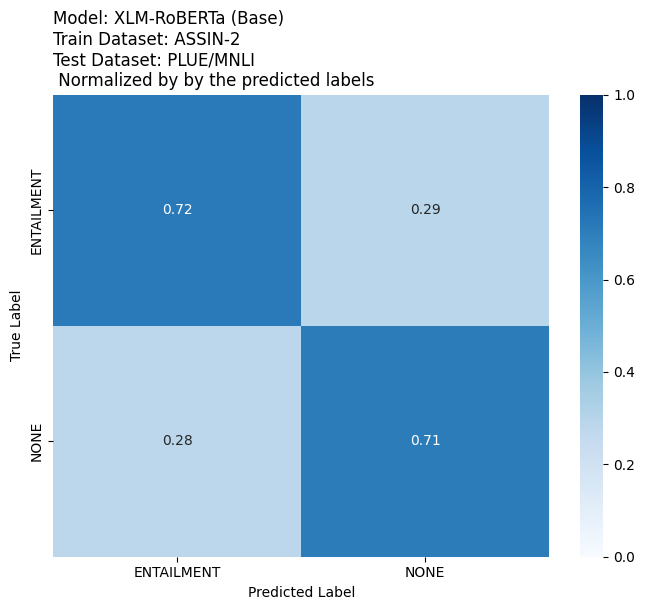

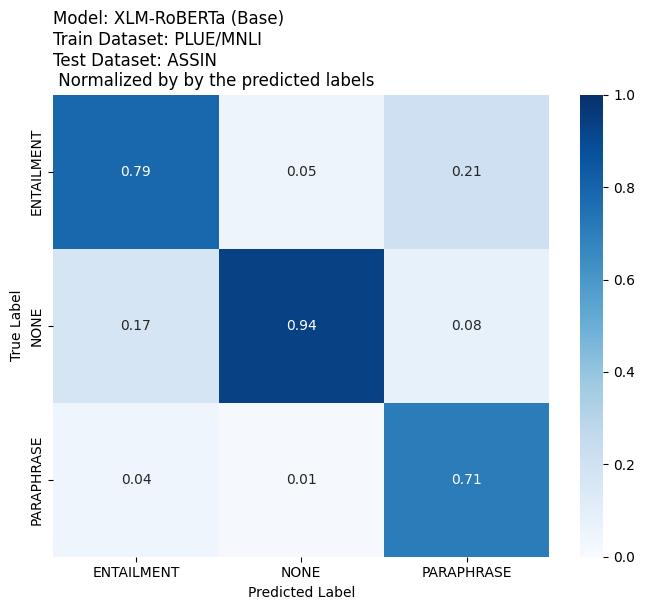

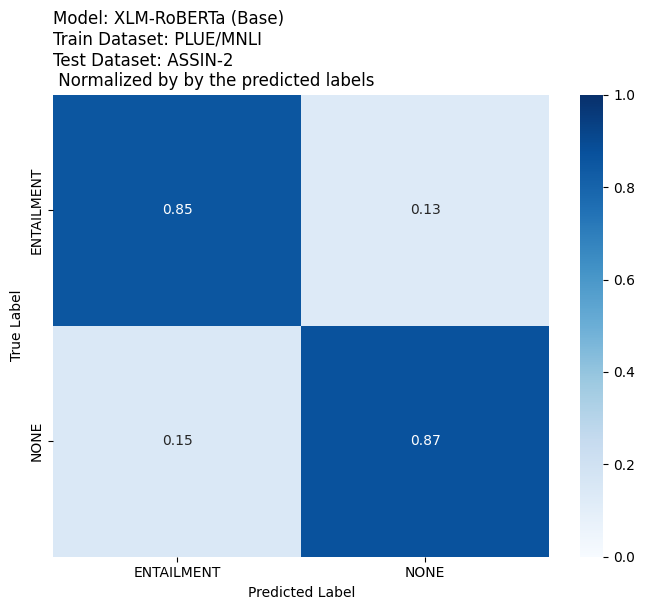

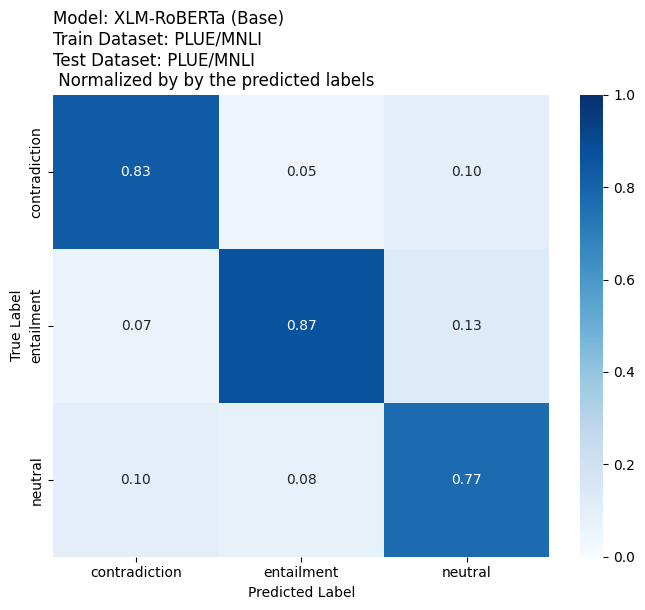

In [6]:
plot_consufion_matrices(grouped, normalize='pred')

In [7]:
"""from datasets import load_dataset, load_metric


def mount_metrics_dataframe(groups: list, df: pd.DataFrame) -> pd.DataFrame:
    accuracy_metric = load_metric("accuracy")
    precision_metric = load_metric("precision")
    recall_metric = load_metric("recall")
    f1_metric = load_metric("f1")

    grouped = df.groupby(groups)
    rows = []
    for (model_name, train_dataset, test_dataset), group in grouped:
        labels = group['label'].unique()
        metrics = {
            'model_name': model_name,
            'test_dataset': test_dataset,
            'train_dataset': train_dataset,
            'accuracy': accuracy_score(group['label'], group['prediction']),
            'f1': f1_score(group['label'], group['prediction'], average='macro'),
            'precision': precision_score(group['label'], group['prediction'], average='macro'),
            'recall': recall_score(group['label'], group['prediction'], average='macro')
        }

        for label in labels:
            binarized_true = (group['label'] == label).astype(int)
            binarized_pred = (group['prediction'] == label).astype(int)
            
            metrics[f'{label}_accuracy'] = accuracy_metric.compute(predictions=binarized_pred, references=binarized_true)['accuracy']
            metrics[f'{label}_f1'] = f1_metric.compute(predictions=binarized_pred, references=binarized_true, average='weighted')['f1']
            metrics[f'{label}_precision'] = precision_metric.compute(predictions=binarized_pred, references=binarized_true, average='weighted')['precision']
            metrics[f'{label}_recall'] = recall_metric.compute(predictions=binarized_pred, references=binarized_true, average='weighted')['recall']

            '''metrics[f'{label}_accuracy'] = accuracy_metric(binarized_true, binarized_pred)
            metrics[f'{label}_f1'] = f1_metric(binarized_true, binarized_pred)
            metrics[f'{label}_precision'] = precision_metric(binarized_true, binarized_pred)
            metrics[f'{label}_recall'] = recall_metric(binarized_true, binarized_pred)'''
        
        rows.append(metrics)

    return pd.DataFrame(rows)"""

'from datasets import load_dataset, load_metric\n\n\ndef mount_metrics_dataframe(groups: list, df: pd.DataFrame) -> pd.DataFrame:\n    accuracy_metric = load_metric("accuracy")\n    precision_metric = load_metric("precision")\n    recall_metric = load_metric("recall")\n    f1_metric = load_metric("f1")\n\n    grouped = df.groupby(groups)\n    rows = []\n    for (model_name, train_dataset, test_dataset), group in grouped:\n        labels = group[\'label\'].unique()\n        metrics = {\n            \'model_name\': model_name,\n            \'test_dataset\': test_dataset,\n            \'train_dataset\': train_dataset,\n            \'accuracy\': accuracy_score(group[\'label\'], group[\'prediction\']),\n            \'f1\': f1_score(group[\'label\'], group[\'prediction\'], average=\'macro\'),\n            \'precision\': precision_score(group[\'label\'], group[\'prediction\'], average=\'macro\'),\n            \'recall\': recall_score(group[\'label\'], group[\'prediction\'], average=\'macro\')

In [8]:
groups =  ['model_name', 'train_dataset', 'test_dataset']
metrics_to_see = ['accuracy', 'f1', 'recall', 'precision']
metrics_df = mount_metrics_dataframe()
metrics_df.to_csv('results.csv', index=False)
metrics_df['test_dataset'] = metrics_df['test_dataset'].map(DATASETS_MAPS)
metrics_df['train_dataset'] = metrics_df['train_dataset'].map(DATASETS_MAPS)
metrics_df['model_name'] = metrics_df['model_name'].map(MODELS_MAP)

In [9]:
print(metrics_df.columns)

Index(['ENTAILMENT_f1', 'ENTAILMENT_precision', 'ENTAILMENT_recall', 'NONE_f1',
       'NONE_precision', 'NONE_recall', 'PARAPHRASE_f1',
       'PARAPHRASE_precision', 'PARAPHRASE_recall', 'accuracy', 'f1', 'loss',
       'model_name', 'precision', 'recall', 'runtime', 'samples',
       'samples_per_second', 'steps_per_second', 'test_dataset', 'test_subset',
       'train_dataset', 'entailment_f1', 'entailment_precision',
       'entailment_recall', 'neutral_f1', 'neutral_precision',
       'neutral_recall', 'predict_samples', 'contradiction_f1',
       'contradiction_precision', 'contradiction_recall'],
      dtype='object')


In [10]:
precision = ".2f"
'''def plot_metrics_results(metrics_df: pd.DataFrame, model_name: str, metric: str):
    plot = metrics_df[metrics_df['model_name'] == model_name].pivot(index = "train_dataset",
                                                                    columns = "test_dataset",
                                                                    values = metric)
    plt.figure(figsize=(8,6))
    sns.heatmap(plot, annot=True, cmap = 'Blues',fmt=precision, vmin=0.5, vmax=1)
    plt.title(f"{metric[0].upper() + metric[1:]} for {model_name}")
    plt.show()'''

'def plot_metrics_results(metrics_df: pd.DataFrame, model_name: str, metric: str):\n    plot = metrics_df[metrics_df[\'model_name\'] == model_name].pivot(index = "train_dataset",\n                                                                    columns = "test_dataset",\n                                                                    values = metric)\n    plt.figure(figsize=(8,6))\n    sns.heatmap(plot, annot=True, cmap = \'Blues\',fmt=precision, vmin=0.5, vmax=1)\n    plt.title(f"{metric[0].upper() + metric[1:]} for {model_name}")\n    plt.show()'

In [11]:
'''def plot_models_benchmark_results(metrics_df: pd.DataFrame, metric: str):
    plot = metrics_df.pivot(index = "test_dataset",columns = "model",values = metric)
    plt.figure(figsize=(8,6))
    sns.heatmap(plot, annot=True, cmap = 'Blues',fmt=precision, vmin=0.5, vmax=1)
    plt.title(f"Models' {metric} comparison")
    plt.xticks(rotation=90)
    plt.show()'''

'def plot_models_benchmark_results(metrics_df: pd.DataFrame, metric: str):\n    plot = metrics_df.pivot(index = "test_dataset",columns = "model",values = metric)\n    plt.figure(figsize=(8,6))\n    sns.heatmap(plot, annot=True, cmap = \'Blues\',fmt=precision, vmin=0.5, vmax=1)\n    plt.title(f"Models\' {metric} comparison")\n    plt.xticks(rotation=90)\n    plt.show()'

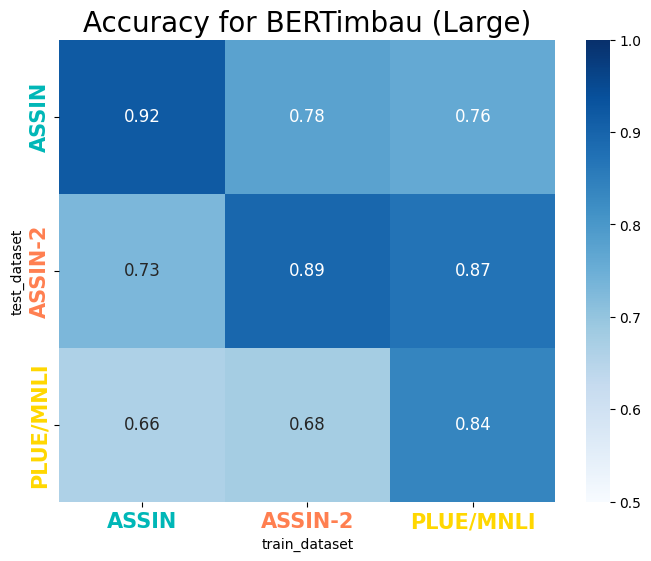

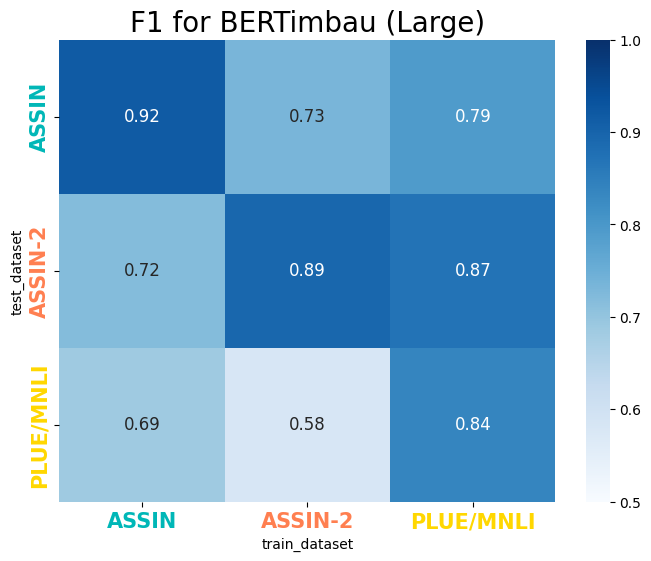

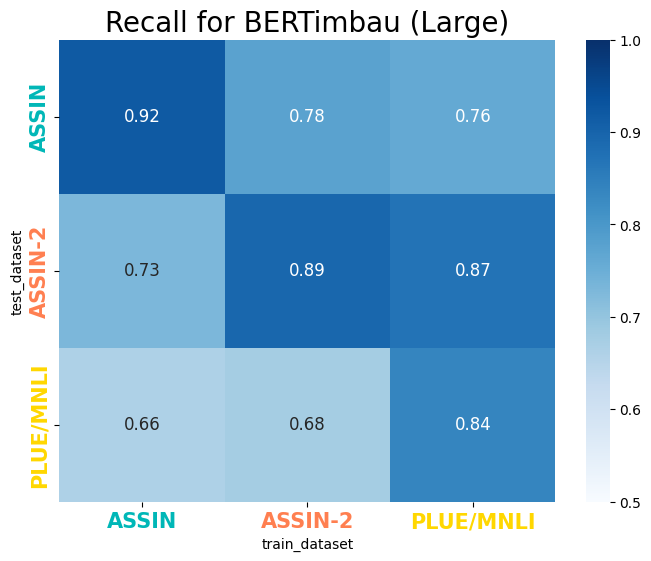

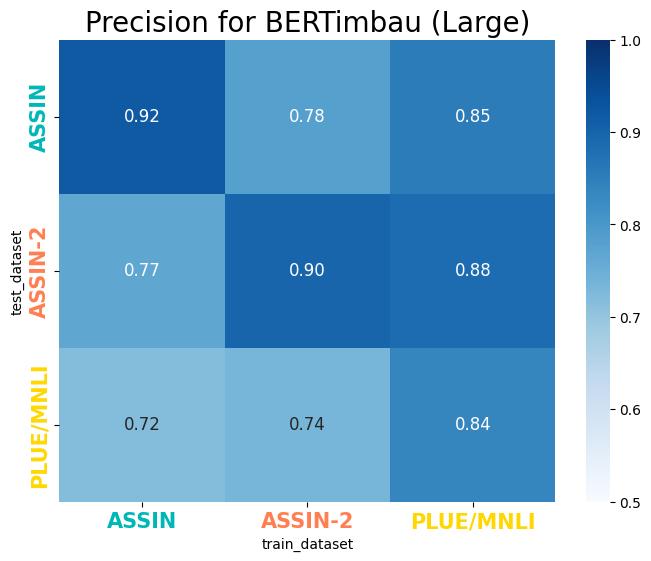

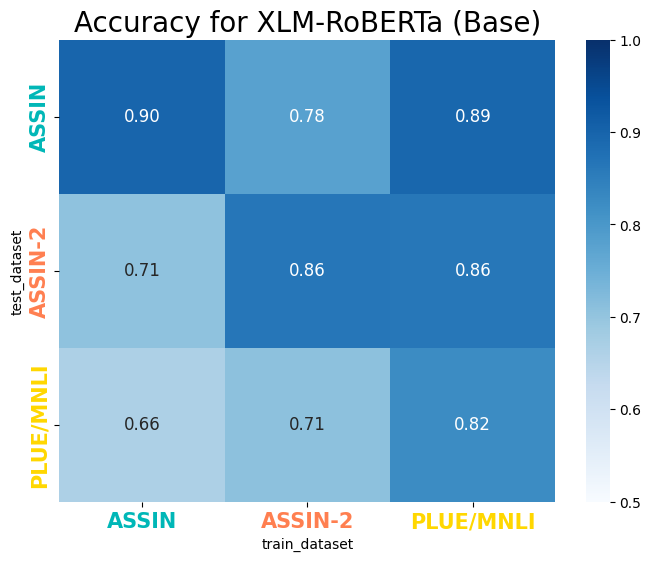

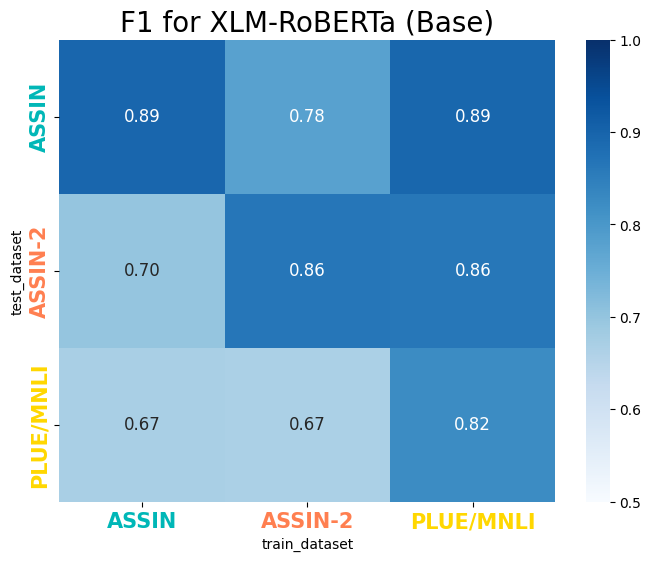

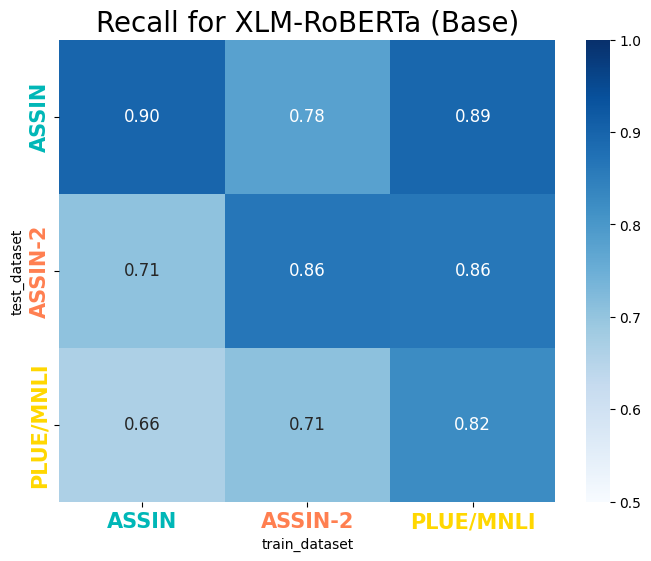

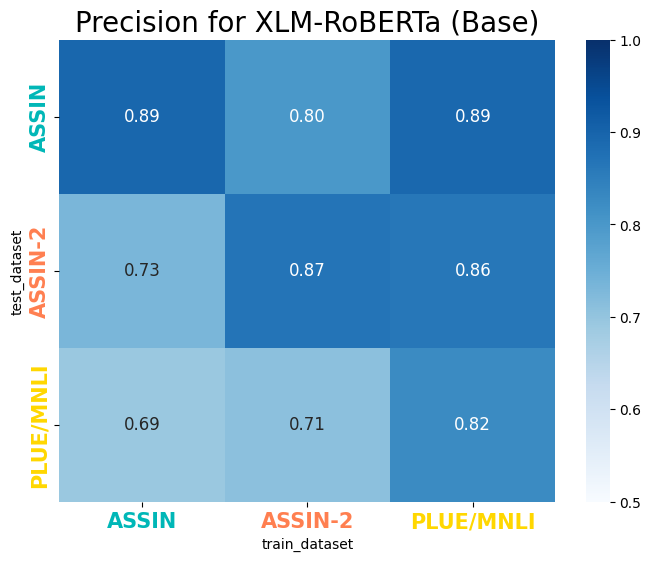

In [12]:
model_names = metrics_df['model_name'].unique()
for model_name in model_names:
    for metric in ['accuracy', 'f1', 'recall', 'precision']:
        plot_metrics_results(metrics_df, model_name, metric)

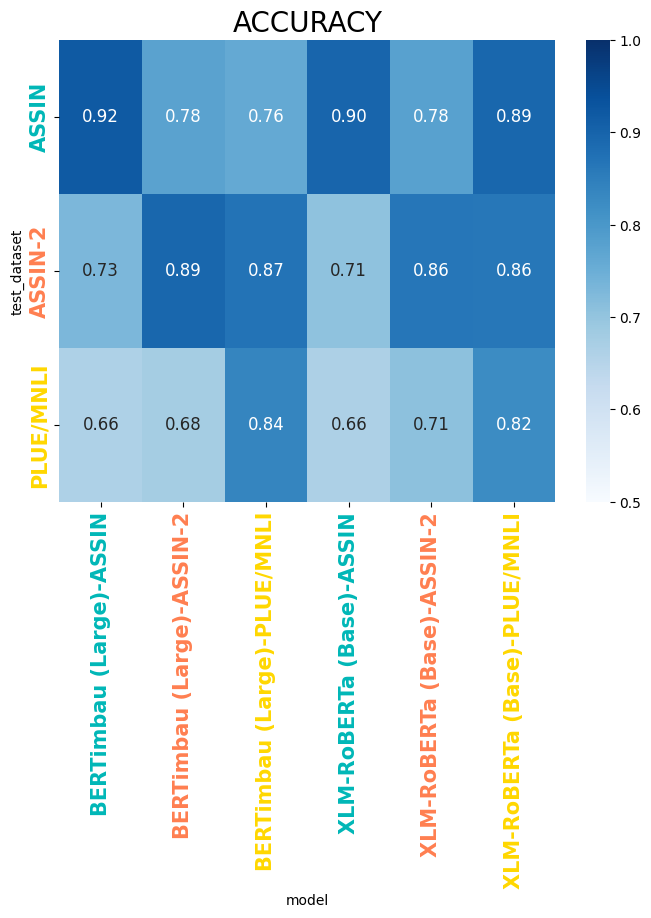

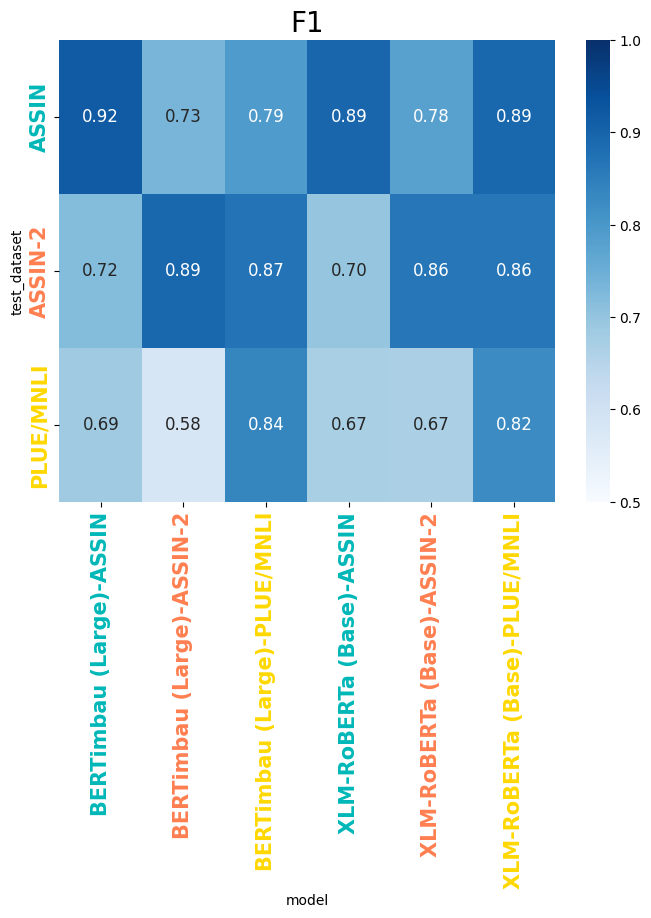

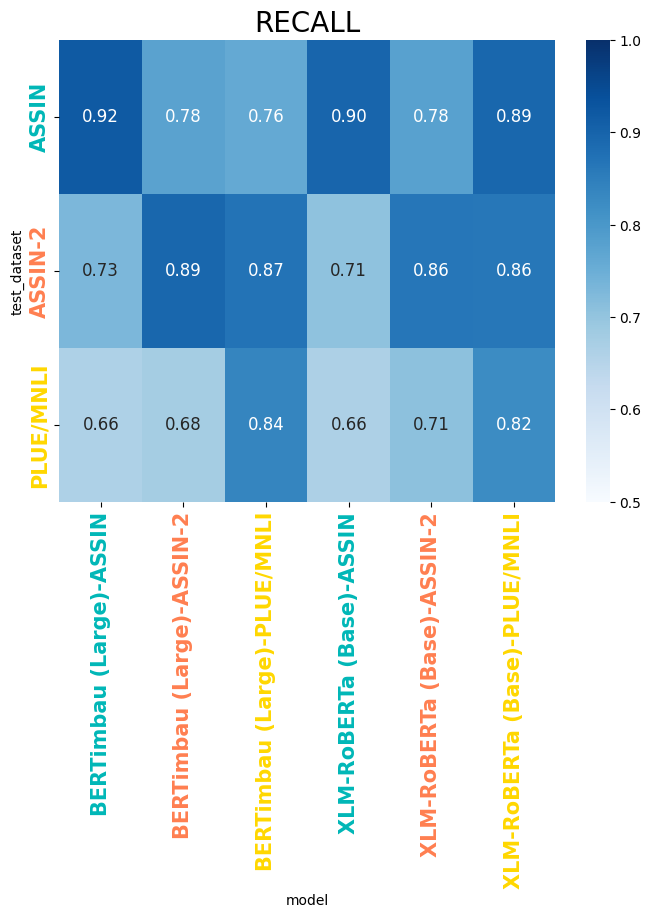

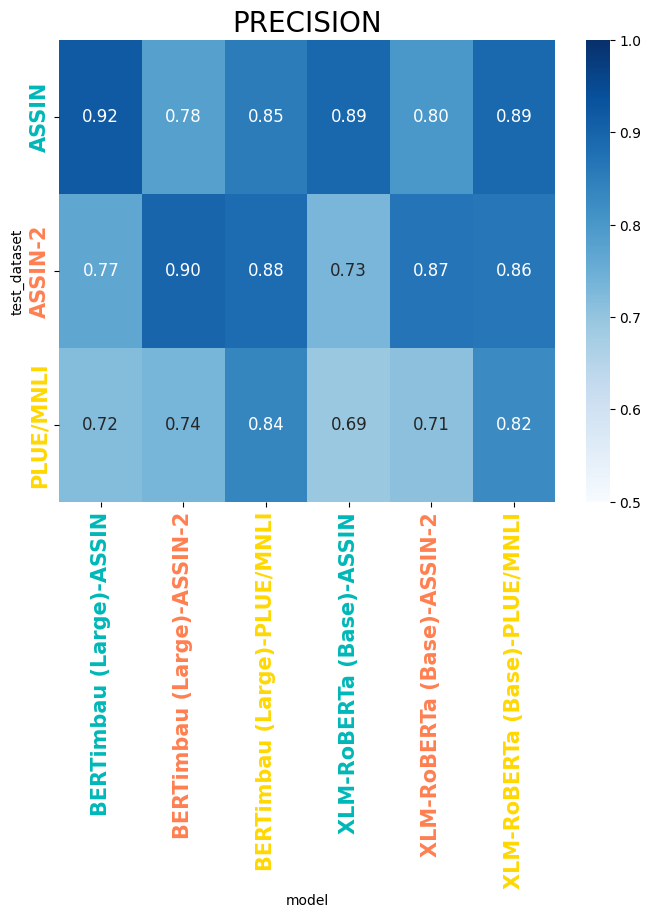

KeyError: 'NONE_accuracy'

In [13]:
metrics_df["model"] = metrics_df["model_name"] + '-' + metrics_df["train_dataset"]
labels = df['label'].unique()
metrics_to_see.extend([label + '_' + metric for label in labels for metric in metrics_to_see])

for metric in metrics_to_see:
    plot_models_benchmark_results(metrics_df, metric)
